# Glassdoor Take home 

### PART 1:  JOB SLOT SALES AND PERFORMANCE DISTRIBUTION

### PART 2:  RETENTION ANALYSIS															

# Code Start Here:

In [1]:
# Import all packages
import pandas as pd
import numpy as np
from datetime import date
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

#from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plot
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read data into dataframe job
job = pd.read_excel("Job Slot Retention Case vCandidate.xlsx", sheetname = "Ex 1 - Job Slot Raw Data")

In [3]:
job.head(3)

,Start Date,End Date,Employer ID,Employer City,Employer State,Number of Slots,Price Paid,Marketplace Value Delivered,Applications,Renewed?
0,2015-02-01,2016-02-29,40,Belmont,California,125,67125.0,147711.043445,9647.7,0
1,2015-12-31,2016-12-30,43,Northbrook,Illinois,100,85025.0,62214.929769,7182.2,1
2,2016-01-02,2017-01-01,72,New York,New York State,100,71600.0,58759.871766,6537.0,0


## Data Sanity Check

In [4]:
# print data structure: # records, # columns, column names and type
print(job.shape)
print(job.info())

(3078, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3078 entries, 0 to 3077
Data columns (total 10 columns):
Start Date                     3078 non-null datetime64[ns]
End Date                       3078 non-null datetime64[ns]
Employer ID                    3078 non-null int64
Employer City                  3078 non-null object
Employer State                 3078 non-null object
Number of Slots                3078 non-null int64
Price Paid                     3078 non-null float64
Marketplace Value Delivered    3078 non-null float64
Applications                   3078 non-null float64
Renewed?                       3078 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 240.5+ KB
None


In [5]:
# check if date range is valid
job_invalid = job[job["Start Date"] > job["End Date"]]
job_invalid.shape
# No invalid date data

(0, 10)

#### Conclusion: No valid record found for Start Date and End Date

In [6]:
# Check if negative value for # slots, price paid, application, marketplace value, or invalid value for renewed
job_negslot = job[job["Number of Slots"] <= 0]
job_negprice = job[job["Price Paid"] <= 0]
job_negvalue = job[job["Marketplace Value Delivered"] < 0]
job_negapp = job[job["Applications"] < 0]
print(job_negslot.shape, job_negprice.shape, job_negvalue.shape, job_negapp.shape)
job["Renewed?"].value_counts()

((0, 10), (0, 10), (0, 10), (0, 10))


1    2087
0     991
Name: Renewed?, dtype: int64

#### Conclusion: No invalid value for #slot, price paid, marketplace value, #application, Renew or not fields

In [7]:
# Chcek Employer State distribution
print(job["Employer State"].nunique(dropna = False))
#job["Employer State"].value_counts()
#job["Employer City"].value_counts()
job[job["Employer City"]==0]["Employer State"].value_counts()

127


0    10
Name: Employer State, dtype: int64

#### Conclusion 1: The file has "na" and "0" values for City and State; 
#### Assumption 1: City with "0" is data error (invalid records); State with "0" (while City has Valid value, like Singapore) is valid
#### Assumption 2: "na" means no specific request location for the job and is valid
#### Conclusion 2: The file includes both International and US market

In [8]:
# Check duplication record
# Given employer can have multiple contract transactions around the same period,
# here I checked if there is duplicated contract transaction records
job.drop_duplicates().shape

(3078, 10)

In [9]:
# Check duplications for repeated customers, and repeat_customers/ job location
print(job[["Employer ID"]].drop_duplicates().shape)
print(job[["Employer ID", "Employer State","Employer City"]].drop_duplicates().shape)

(2757, 1)
(3053, 3)


#### Conclusion: No duplication based on contract transaction data; 
#### Conclusion: Employer can purchase multiple contracts due to (1) different job location, (2) renew, and/or (3) purchase multiple contracts around the time

## Data Cleaning

In [10]:
# delete invalid values, both city has 0 values
job = job[job["Employer City"] != 0]
job.shape

(3068, 10)

In [11]:
# Fill "0" in field employer state with the value in employer City
def fillcity(row):
    if row["Employer State"] == 0:
        return row["Employer City"]
    else:
        return row["Employer State"]
job["Employer State"] = job.apply(lambda x: fillcity(x), axis = 1)

In [12]:
#job["Employer State"].value_counts()

## PART 1:  JOB SLOT SALES AND PERFORMANCE DISTRIBUTION

### What is the variation across the Job Slot packages we sell?  

#### Price Distribution

In [13]:
# Price Paid: Statistics
job["Price Paid"].describe(percentiles=[.01, 0.02, .05, .1, .25, .5, .75, .9, .95, 0.98, .99])

count      3068.000000
mean      22365.443325
std       15614.701211
min         205.402500
1%         5788.384397
2%        10740.000000
5%        10740.000000
10%       10740.000000
25%       13425.000000
50%       17094.500000
75%       26850.000000
90%       40275.000000
95%       53700.000000
98%       67125.000000
99%       80550.000000
max      273870.000000
Name: Price Paid, dtype: float64

In [14]:
# Floor/ Cap the field at 1%/99% percentile
price = [job["Price Paid"].quantile(0.01), job["Price Paid"].quantile(0.95)]
job["Price_paid_mani"] = job["Price Paid"].apply(lambda x: price[0] if x < price[0] else x)
job["Price_paid_mani"] = job["Price_paid_mani"].apply(lambda x: price[1] if x > price[1] else x)

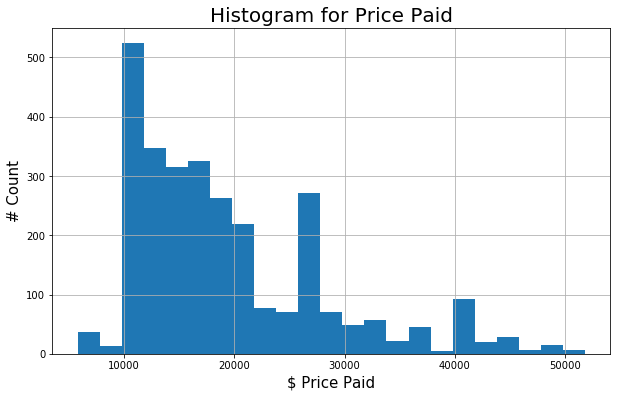

In [15]:
bin_values = np.arange(start= job["Price_paid_mani"].min(), stop=job["Price_paid_mani"].max(), step=2000)
price_plot = job['Price_paid_mani'].hist(bins=bin_values, figsize=[10,6])
price_plot.set_title("Histogram for Price Paid", fontsize = 20)
price_plot.set_xlabel("$ Price Paid", fontsize = 15)
price_plot.set_ylabel("# Count", fontsize = 15)

### Popular Package

In [16]:
## Popularity by # puchased
pkg_purchase = job["Number of Slots"].value_counts().to_frame().rename(columns = {"index": "# Slots","Number of Slots": "# Purchase"})
pkg_purchase.sort_values(by = "# Purchase", ascending = False, inplace = True)

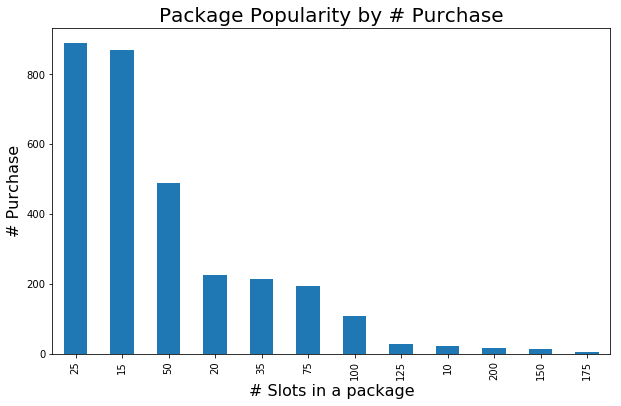

In [17]:
purchase_plot = pkg_purchase.plot(kind='bar', figsize = [10,6],legend=None)
purchase_plot.set_xlabel("# Slots in a package", fontsize = 16)
purchase_plot.set_ylabel("# Purchase", fontsize = 16)
purchase_plot.set_title("Package Popularity by # Purchase", fontsize = 20)

In [18]:
## Popularity by # Employer purchased
pkg_employer = job.drop_duplicates(["Number of Slots","Employer ID"]).groupby("Number of Slots").count()[["Employer ID"]].rename(columns = {"Employer ID": "# User"})
pkg_employer.sort_values(by = "# User", ascending = False, inplace = True)

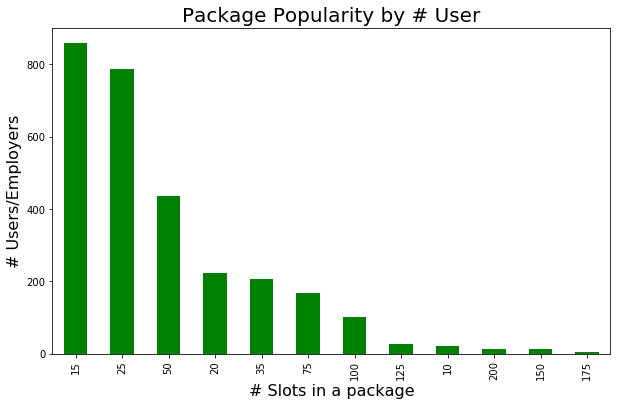

In [19]:
employer_plot = pkg_employer.plot(kind='bar',legend=None,figsize = [10,6], color ="green")
employer_plot.set_xlabel("# Slots in a package", fontsize = 16)
employer_plot.set_ylabel("# Users/Employers", fontsize = 16)
employer_plot.set_title("Package Popularity by # User", fontsize = 20)

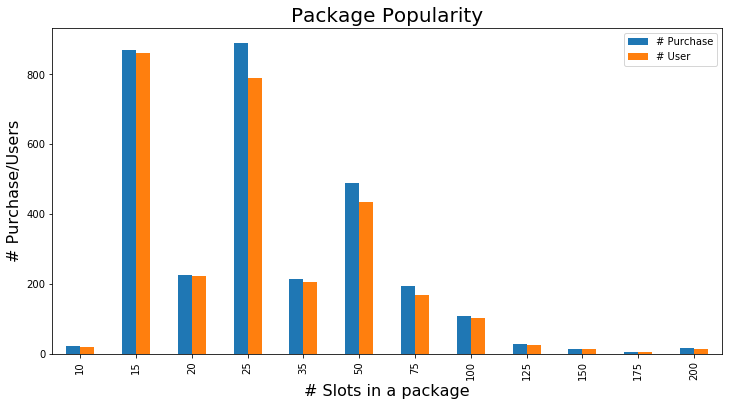

In [20]:
# Combine 2 charts
popular = pkg_purchase.merge(pkg_employer, left_index = True, right_index = True, how = "outer")
popular_plot = popular.plot(kind='bar',legend= True,figsize = [12,6])
popular_plot.set_xlabel("# Slots in a package", fontsize = 16)
popular_plot.set_ylabel("# Purchase/Users", fontsize = 16)
popular_plot.set_title("Package Popularity", fontsize = 20)

### Conclusion 1: The most popular package measured by # Times purchased is the one with 25 job slots;
### Conclusion 2: The most popular package measured by # users/employers is the one with 15 job slots

## Term variation

In [21]:
### Create term for each contract
from dateutil import rrule
import datetime
def day_between(start_date, end_date):
    days = rrule.rrule(rrule.DAILY, dtstart=start_date, until=end_date)
    return days.count()
job["term"] = job.apply(lambda row: day_between(row["Start Date"], row["End Date"]), axis = 1)

In [23]:
job["term"].describe(percentiles=[.01, 0.02, .05, .1, .25, .5, .75, .9, .95, 0.98, .99])

count    3068.000000
mean      346.041069
std        73.959362
min         1.000000
1%         37.680000
2%         92.000000
5%        154.350000
10%       275.000000
25%       365.000000
50%       366.000000
75%       366.000000
90%       366.000000
95%       366.000000
98%       397.000000
99%       427.000000
max       732.000000
Name: term, dtype: float64

In [24]:
# Floor/ Cap at 1% and 99%
term_perc = [job["term"].quantile(0.01), job["term"].quantile(0.99)]
job["term_mani"] = job["term"].apply(lambda x: term_perc[0] if x < term_perc[0] else x)
job["term_mani"] = job["term_mani"].apply(lambda x: term_perc[1] if x > term_perc[1] else x)

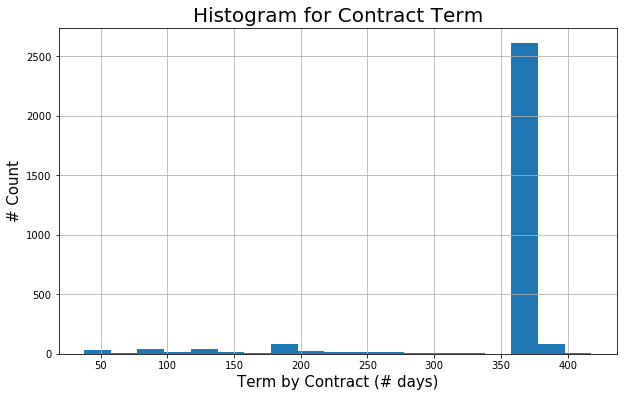

In [25]:
bin_values = np.arange(start= job["term_mani"].min(), stop=job["term_mani"].max(), step=20)
term_plot = job['term_mani'].hist(bins=bin_values, figsize=[10,6])
term_plot.set_title("Histogram for Contract Term", fontsize = 20)
term_plot.set_xlabel("Term by Contract (# days)", fontsize = 15)
term_plot.set_ylabel("# Count", fontsize = 15)

## What metrics should we use to compare delivery performance across customers?

### Customer level matrix: Dedup Contract-level dataframe into Employer-level dataframe

In [26]:
# Combine "City" and "State" into one column: Location
job["Location"] = job["Employer City"].str.strip() + str(", ") + job["Employer State"].str.strip()
print(job["Location"].nunique(dropna = False))

947


In [27]:
# Create indicator for Domestic vs. international market
# job posted in domestic or international market
US_list = ["Alabama","Alaska","Arizona","Arkansas", "California", "Colorado", "Connecticut","Delaware",
           "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana","Iowa","Kansas","Kentucky",
           "Louisiana","Maine", "Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri",
           "Montana","Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York State", "New York"
           "North Carolina", "North Dakota", "Ohio","Oklahoma","Oregon", "Pennsylvania","Rhode Island",
           "South Carolina","South Dakota", "Tennessee","Texas", "Utah","Vermont", "Virginia","Washington","Washington State"
           "West Virginia","Wisconsin","Wyoming","District of Columbia"]

def mkt_def(state):
    if state == "na":
        return -1
    elif state in US_list:
        return 1
    else:
        return 0
    
job["US_MKT"] = job["Employer State"].apply(lambda x: mkt_def(x))

In [28]:
job.US_MKT.value_counts()

 1    1846
-1     834
 0     388
Name: US_MKT, dtype: int64

In [29]:
# Create customer level dataframe
employer_dup = job.groupby("Employer ID")["Employer ID"].count().to_frame().rename(columns = {"Employer ID":"Count"}).reset_index()

In [30]:
# check # unique Employer ID
print(employer_dup.shape[0])

2748


In [31]:
multi_pkg = employer_dup.merge(job, left_on = "Employer ID", right_on = "Employer ID", how = "left")

In [396]:
#print(one_pkg.shape[0], multi_pkg.shape[0])

(2449, 619)


In [ ]:
# Determine grouping/deduping logic for Employers with multiple packages
# sum: # Slots, price paid, market value delivered,applications, duration
# Most recent: End date, Employer city, Employer State, last time purchase information, renewed or not
# Early start: Start date
# Agg: # job locations, # packages purchased, # renewed, # na

In [32]:
# sum: # Slots, price paid, market value delivered,applications, duration
# renewed (including the last time renewed record) & #NA 
multi_pkg["NA_num"] = multi_pkg["Employer City"].apply(lambda x: 1 if x == "na" else 0)
employer_sum = multi_pkg.groupby("Employer ID")["Number of Slots","Price Paid", "Marketplace Value Delivered","Applications","Renewed?","term","NA_num"].sum().reset_index()
employer_sum.rename(columns = {"Renewed?": "# Renewed"}, inplace = True)
print(employer_sum.shape, employer_sum.drop_duplicates("Employer ID").shape)
employer_sum.dtypes

((2748, 8), (2748, 8))


Employer ID                      int64
Number of Slots                  int64
Price Paid                     float64
Marketplace Value Delivered    float64
Applications                   float64
# Renewed                        int64
term                             int64
NA_num                           int64
dtype: object

In [33]:
# Users have Purchase at the same time
multi_st = multi_pkg.groupby(["Start Date","End Date"])["Employer ID"].value_counts().to_frame().rename(columns = {"Employer ID": "Count ST"})
multi_st = multi_st.reset_index().sort_values(by = ["Employer ID","Start Date","End Date"], ascending = False)
multi_pkg2 = multi_st[multi_st["Count ST"] > 1].merge(multi_pkg, left_on = ["Employer ID","Start Date","End Date"],right_on = ["Employer ID","Start Date","End Date"], how = "right", indicator = True)

In [35]:
multi_purchase_st = multi_pkg2[multi_pkg2["_merge"]== "both"].groupby(["Employer ID","Start Date","End Date"])["Number of Slots","Price Paid", "Marketplace Value Delivered","Applications","Renewed?","term"].sum()
multi_purchase_st.reset_index(inplace = True)

In [36]:
# Combine users have purchases at the same time and 1 purchase at a time
single_purchase_st = multi_pkg2[multi_pkg2["_merge"]=="right_only"][["Employer ID", "Start Date","End Date","Number of Slots","Price Paid","Marketplace Value Delivered","Applications","Renewed?","term"]]
multi_pkg_reset = pd.concat([single_purchase_st, multi_purchase_st])

In [37]:
# Get last record
multi_pkg_reset = multi_pkg_reset.sort_values(by = ["Employer ID","End Date","Start Date","Renewed?"], ascending = False)
employer_last = multi_pkg_reset.drop_duplicates(["Employer ID"], keep= "first").drop("Start Date", axis = 1)
employer_last.rename(columns = {"End Date": "Last Date", "Number of Slots": "Last #Slots",
                                "Price Paid": "Last Price Paid","Marketplace Value Delivered": "Last MKT Value",
                                "Applications": "Last Apps", "Renewed?": "End Renewed", "term": "last term"}, inplace= True)
employer_last.head(3)

,Employer ID,Last Date,Last #Slots,Last Price Paid,Last MKT Value,Last Apps,End Renewed,last term
3067,107337,2016-12-31,50,4533.6941,3394.84598,211.0,1,44
3066,105891,2017-01-06,10,12530.0000,3090.77510,165.4,1,68
3065,103826,2017-01-26,15,16110.0000,2451.16872,203.2,0,91


In [38]:
employer_last.shape

(2748, 8)

In [39]:
# First record: Early date
multi_pkg_first = multi_pkg_reset.sort_values(by = ["Employer ID","Start Date"], ascending = True)
multi_pkg_first = multi_pkg_first.drop_duplicates(["Employer ID"], keep = "first")[["Employer ID","Start Date"]]
employer_first = multi_pkg_first.rename(columns = {"Start Date": "Earliest Date"})
employer_first.head(1)

,Employer ID,Earliest Date
33,40,2015-02-01


In [40]:
# Agg: # job locations, # States, domestic or international, # packages purchased, # renewed, # na
# job location: count unique values
location_dedup = multi_pkg.groupby(["Employer ID"])["Location"].nunique().to_frame().rename(columns = {"Location": "Loc count"})
location_dedup.reset_index(inplace = True)
# States: count unique values
state_dedup = multi_pkg.groupby(["Employer ID"])["Employer State"].nunique().to_frame().rename(columns = {"Employer State": "State count"})
state_dedup.reset_index(inplace = True)

In [41]:
# check duplications
print(location_dedup.shape, location_dedup.drop_duplicates("Employer ID").shape)
print(state_dedup.shape, state_dedup.drop_duplicates("Employer ID").shape)

((2748, 2), (2748, 2))
((2748, 2), (2748, 2))


In [42]:
# both or only international
multi_pk3 = multi_pkg
multi_pk3["int_mkt"] = multi_pk3["US_MKT"].apply(lambda x: 1 if x == 0 else 0)
multi_pk3["us_mkt"] = multi_pk3["US_MKT"].apply(lambda x: 1 if x == 1 else 0)
mkt_dedup = multi_pk3.groupby(["Employer ID"]).max()[["int_mkt","us_mkt"]].reset_index()
def jobmkt(row):
    if row["int_mkt"] == 1 and row["us_mkt"] == 0:
        return "International"
    elif row["int_mkt"] == 0 and row["us_mkt"] == 1:
        return "Domestic"
    elif row["int_mkt"] == 1 and row["us_mkt"] ==1:
        return "Both"
    else:
        return "Unknown"
    
mkt_dedup["job_mkt"] = mkt_dedup.apply(lambda row: jobmkt(row),axis = 1)

In [43]:
print(mkt_dedup.shape, mkt_dedup.drop_duplicates("Employer ID").shape)
mkt_dedup.head(3)

((2748, 4), (2748, 4))


,Employer ID,int_mkt,us_mkt,job_mkt
0,40,0,1,Domestic
1,43,0,1,Domestic
2,72,0,1,Domestic


In [44]:
# packages purchased, # renewed, # NA
# packages purchased (# time repeated)
pkg_dedup = multi_pkg.groupby("Employer ID")["Employer ID"].count().to_frame().rename(columns = {"Employer ID": "# Packages"}).reset_index()

In [45]:
# Check Employer level duplications ;
print(pkg_dedup.shape, pkg_dedup.drop_duplicates("Employer ID").shape)

((2748, 2), (2748, 2))


In [46]:
# Combine aggregated matrix into 1 df
employer_agg = location_dedup.merge(state_dedup, left_on = "Employer ID", right_on = "Employer ID", how = "left")
employer_agg = employer_agg.merge(pkg_dedup, left_on = "Employer ID", right_on = "Employer ID", how = "left")
employer_agg = employer_agg.merge(mkt_dedup, left_on = "Employer ID", right_on = "Employer ID", how = "left")
employer_agg.shape[0]

2748

In [47]:
employer_agg.head()

,Employer ID,Loc count,State count,# Packages,int_mkt,us_mkt,job_mkt
0,40,1,1,1,0,1,Domestic
1,43,1,1,1,0,1,Domestic
2,72,2,2,2,0,1,Domestic
3,94,1,1,1,0,1,Domestic
4,102,1,1,1,1,0,International


In [48]:
# Combine all multi-package df together
employer_all = employer_sum.merge(employer_last, left_on = "Employer ID", right_on = "Employer ID", how = "left")
employer_all = employer_all.merge(employer_first, left_on = "Employer ID", right_on = "Employer ID", how = "left")
employer_all = employer_all.merge(employer_agg, left_on = "Employer ID", right_on = "Employer ID", how = "left")
print(employer_all.shape[0])
print(employer_all.dtypes)

2748
Employer ID                             int64
Number of Slots                         int64
Price Paid                            float64
Marketplace Value Delivered           float64
Applications                          float64
# Renewed                               int64
term                                    int64
NA_num                                  int64
Last Date                      datetime64[ns]
Last #Slots                             int64
Last Price Paid                       float64
Last MKT Value                        float64
Last Apps                             float64
End Renewed                             int64
last term                               int64
Earliest Date                  datetime64[ns]
Loc count                               int64
State count                             int64
# Packages                              int64
int_mkt                                 int64
us_mkt                                  int64
job_mkt                      

In [49]:
# Use the set same data structure for one_pkg
employer_all.head(1)

,Employer ID,Number of Slots,Price Paid,Marketplace Value Delivered,Applications,# Renewed,term,NA_num,Last Date,Last #Slots,...,Last Apps,End Renewed,last term,Earliest Date,Loc count,State count,# Packages,int_mkt,us_mkt,job_mkt
0,40,125,67125.0,147711.043445,9647.7,0,394,0,2016-02-29,125,...,9647.7,0,394,2015-02-01,1,1,1,0,1,Domestic


### Delivery Performance Matrix
#### Application matrix: app/ package, app/day, app/slot
#### Cost matrix: Cost per app, Cost per day
#### Marketplace Value matrix: Mkt value per app, Mkt value to Cost ratio
#### Customer gain: total gain, per day, per app

### Job Slot Performance: Application Matrix

In [50]:
# application/package, application per day, application per slot
employer_all["app_per_pkg"] = employer_all["Applications"]/employer_all["# Packages"]
employer_all["app_per_day"] = employer_all["Applications"]/employer_all["term"]
employer_all["app_per_slot"] = employer_all["Applications"]/ employer_all["Number of Slots"]

In [51]:
# truncate to 2-3 decimals for new attributes
employer_all = employer_all.round({"app_per_pkg":2, "app_per_day": 2, "app_per_slot":2, "app_per_slot_day":3})
#employer_all.head()

In [52]:
# Apps
def hist_plot(colname,step,category, floor, cap):
    temp = employer_all[["Employer ID", colname]]
    print(temp[colname].describe(percentiles = [0.01, 0.02, 0.05, 0.1, 0.25,0.5,0.75,0.9,0.95,0.98,0.99]))
    pkg_value = [temp[colname].quantile(floor),temp[colname].quantile(cap)]
    temp.loc[:, colname + '_mani'] = temp[colname].apply(lambda x: pkg_value[0] if x < pkg_value[0] else x)
    temp.loc[:, colname + '_mani'] = temp[colname + '_mani'].apply(lambda x: pkg_value[1] if x > pkg_value[1] else x)
    bin_values = np.arange(start= temp[colname + '_mani'].min(), stop=temp[colname + '_mani'].max(), step=step)
    app_plot = temp[colname + '_mani'].hist(bins=bin_values, figsize=[10,6])
    app_plot.set_title("Histogram for " + category, fontsize = 20)
    app_plot.set_xlabel(colname, fontsize = 15)
    app_plot.set_ylabel("# Count", fontsize = 15)
    #print(temp[colname + '_mani'].max())

count     2748.000000
mean      1671.789516
std       1753.134281
min          0.100000
1%          53.714000
2%          94.152000
5%         215.157500
10%        366.510000
25%        743.025000
50%       1240.500000
75%       2043.475000
90%       3318.340000
95%       4624.920000
98%       6283.808000
99%       7512.647000
max      50686.700000
Name: app_per_pkg, dtype: float64


C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


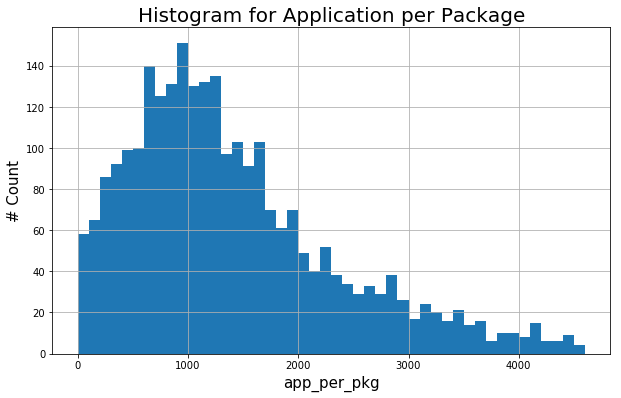

In [53]:
hist_plot("app_per_pkg",100,"Application per Package",0, 0.95)

count    2748.000000
mean        4.800459
std         4.889811
min         0.000000
1%          0.204700
2%          0.400000
5%          0.790000
10%         1.210000
25%         2.197500
50%         3.570000
75%         5.900000
90%         9.449000
95%        12.823000
98%        17.615000
99%        21.144200
max       138.490000
Name: app_per_day, dtype: float64


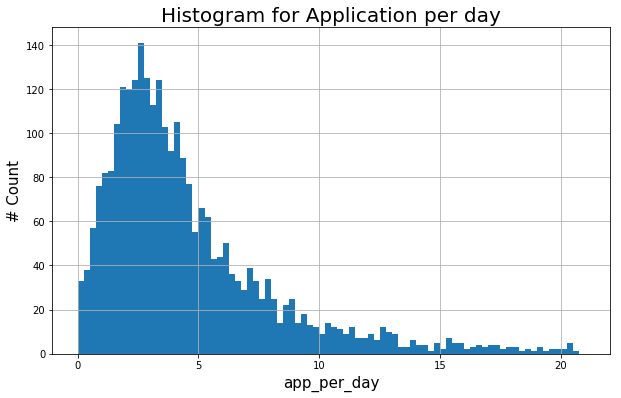

In [54]:
hist_plot("app_per_day",0.25,"Application per day",0, 0.99)

count    2748.000000
mean       50.292857
std        26.648375
min         0.000000
1%          3.015200
2%          4.888200
5%         10.750500
10%        17.628000
25%        32.380000
50%        49.065000
75%        65.400000
90%        81.976000
95%        94.313500
98%       108.247400
99%       117.696500
max       506.870000
Name: app_per_slot, dtype: float64


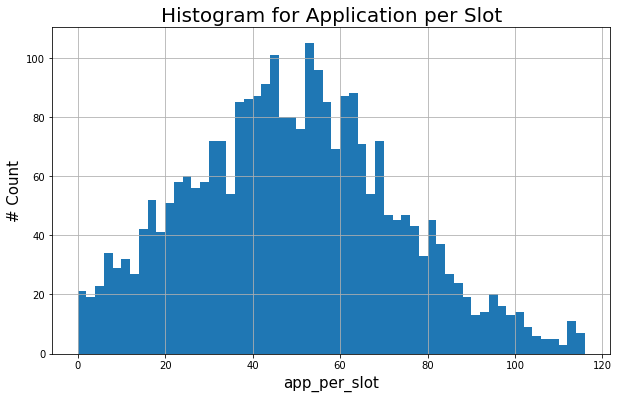

In [55]:
hist_plot("app_per_slot",2,"Application per Slot",0, 0.99)

In [ ]:
#### Cost matrix: Cost per app, Cost per day

In [56]:
employer_all["Cost_per_app"] = employer_all["Price Paid"]/employer_all["Applications"]
employer_all["Cost_per_pkg"] = employer_all["Price Paid"]/employer_all["# Packages"]
employer_all["Cost_per_day"] = employer_all["Price Paid"]/employer_all["term"]
employer_all["Cost_per_slot"] = employer_all["Price Paid"]/employer_all["Number of Slots"]
#employer_all.head(5)

In [57]:
# truncate to 2-3 decimals for new attributes
employer_all = employer_all.round({"Cost_per_app":3, "Cost_per_pkg": 0, "Cost_per_day":3, "Cost_per_day":0, "Cost_per_slot":0})

count      2748.000000
mean        181.399993
std        5112.280605
min           1.624000
1%            6.475810
2%            7.000400
5%            7.837900
10%           8.783700
25%          10.624250
50%          13.809500
75%          20.950250
90%          37.992900
95%          65.376300
98%         147.428380
99%         243.278030
max      214800.000000
Name: Cost_per_app, dtype: float64


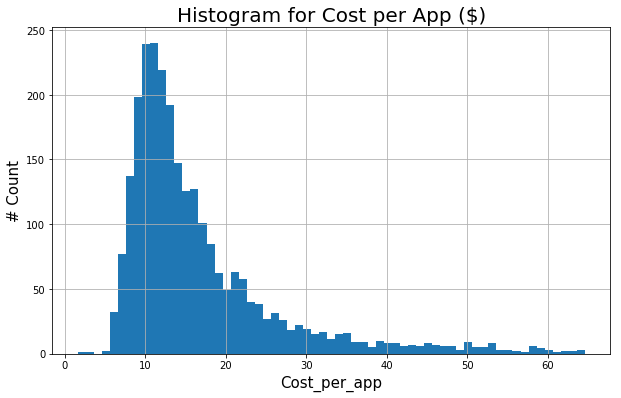

In [58]:
hist_plot("Cost_per_app",1,"Cost per App ($)",0,  0.95)

count      2748.000000
mean      22225.608443
std       15410.237451
min        1432.000000
1%        10069.000000
2%        10740.000000
5%        10740.000000
10%       10740.000000
25%       13425.000000
50%       17005.000000
75%       26850.000000
90%       40275.000000
95%       53700.000000
98%       67125.000000
99%       80550.000000
max      273870.000000
Name: Cost_per_pkg, dtype: float64


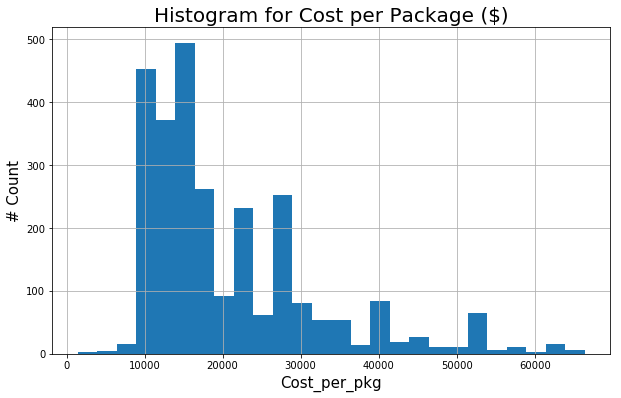

In [59]:
hist_plot("Cost_per_pkg",2500,"Cost per Package ($)",0,  0.98)

count     2748.000000
mean       725.492722
std        387.581325
min         54.000000
1%         293.350000
2%         358.000000
5%         490.350000
10%        537.000000
25%        609.000000
50%        716.000000
75%        806.000000
90%        955.000000
95%       1074.000000
98%       1217.600000
99%       1353.420000
max      18258.000000
Name: Cost_per_slot, dtype: float64


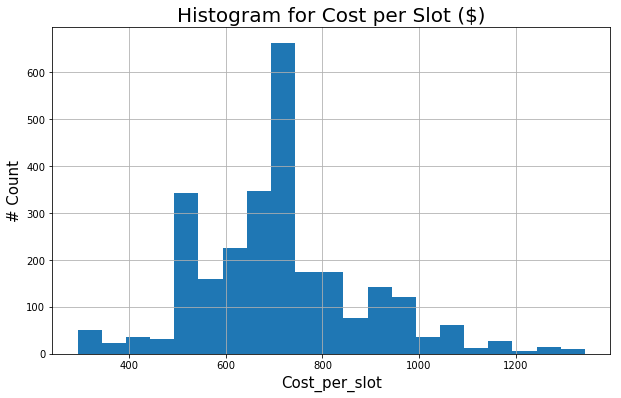

In [60]:
hist_plot("Cost_per_slot",50,"Cost per Slot ($)",0.01, 0.99)

count    2748.000000
mean       68.872271
std        78.653980
min        25.000000
1%         29.000000
2%         29.000000
5%         29.000000
10%        29.000000
25%        37.000000
50%        49.000000
75%        77.250000
90%       123.000000
95%       158.650000
98%       212.180000
99%       262.650000
max      2983.000000
Name: Cost_per_day, dtype: float64


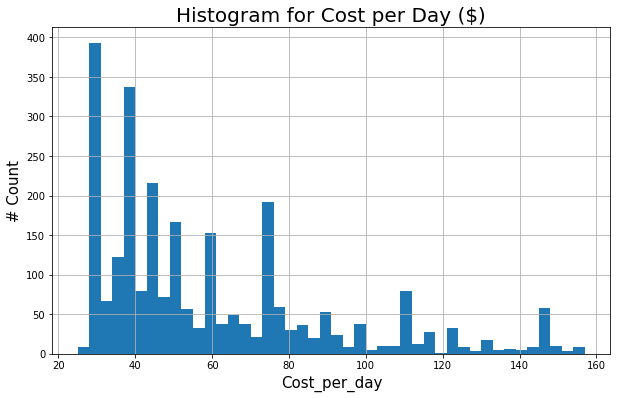

In [61]:
hist_plot("Cost_per_day",3,"Cost per Day ($)",0, 0.95)

In [ ]:
#### Marketplace Value matrix: Mkt value per app, Mkt value to Cost ratio

In [62]:
employer_all["MV_per_app"] = employer_all["Marketplace Value Delivered"]/employer_all["Applications"]
employer_all["MV_Cost"] = employer_all["Marketplace Value Delivered"]/employer_all["Price Paid"]
employer_all["MV_pkg"] = employer_all["Marketplace Value Delivered"]/employer_all["# Packages"]
#employer_all.head(3)

In [63]:
# truncate to 2-3 decimals for new attributes
employer_all = employer_all.round({"MV_per_app":2, "MV_Cost": 3})

count    2748.000000
mean       12.745360
std         3.288512
min         3.250000
1%          5.897600
2%          6.528800
5%          7.450000
10%         8.500000
25%        10.530000
50%        12.680000
75%        14.900000
90%        16.933000
95%        18.026500
98%        19.210000
99%        20.200600
max        47.900000
Name: MV_per_app, dtype: float64


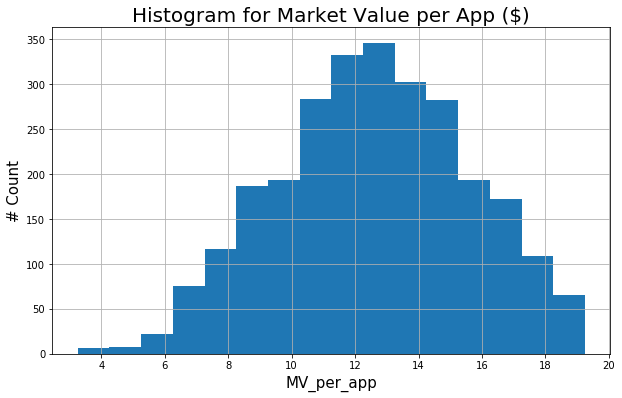

In [64]:
hist_plot("MV_per_app",1,"Market Value per App ($)",0, 0.99)

count    2748.000000
mean        0.891144
std         0.476176
min         0.000000
1%          0.047470
2%          0.077940
5%          0.194700
10%         0.331000
25%         0.602000
50%         0.853500
75%         1.148250
90%         1.455000
95%         1.671950
98%         1.960480
99%         2.164120
max         9.618000
Name: MV_Cost, dtype: float64


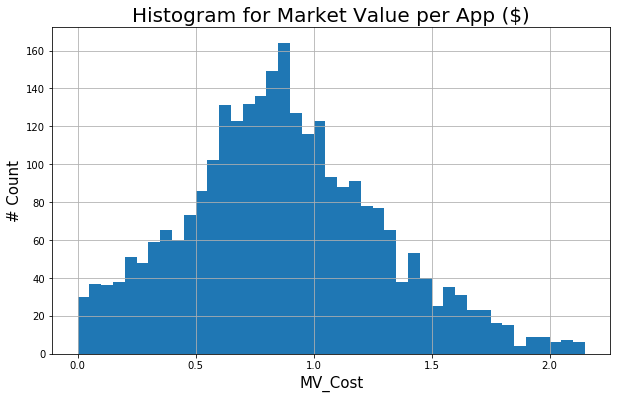

In [65]:
hist_plot("MV_Cost",0.05,"Market Value per App ($)",0, 0.99)

In [ ]:
#### Customer gain: total gain, per day, per app

In [66]:
employer_all["Employer_Gain"] = employer_all["Marketplace Value Delivered"] - employer_all["Price Paid"]
employer_all["Gain_per_app"] = employer_all["Employer_Gain"]/employer_all["Applications"]
employer_all["Gain_per_day"] = employer_all["Employer_Gain"]/employer_all["term"]
employer_all["Gain_per_pkg"] = employer_all["Employer_Gain"]/employer_all["# Packages"]
employer_all["ROI"] = employer_all["Employer_Gain"]/ employer_all["Price Paid"]
#employer_all.head(3)

count      2748.000000
mean      -1896.933347
std       19336.996676
min     -256445.363140
1%       -35876.808959
2%       -30013.592514
5%       -19676.861042
10%      -13908.175409
25%       -7816.150454
50%       -2822.282259
75%        2824.403413
90%        9992.431203
95%       16357.376390
98%       30652.978655
99%       43873.628891
max      709627.907879
Name: Employer_Gain, dtype: float64


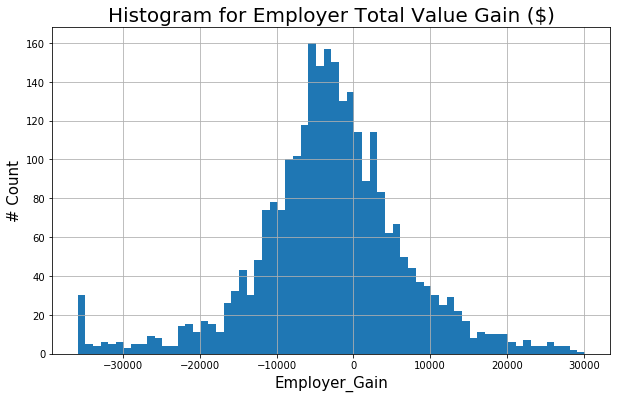

In [67]:
hist_plot("Employer_Gain",1000,"Employer Total Value Gain ($)",0.01, 0.98)

count      2748.000000
mean       -168.654560
std        5112.127233
min     -214774.224000
1%         -232.722300
2%         -133.623835
5%          -51.444595
10%         -24.293628
25%          -7.651671
50%          -1.955134
75%           1.628989
90%           4.411632
95%           5.989648
98%           7.796012
99%           8.725533
max          22.042395
Name: Gain_per_app, dtype: float64


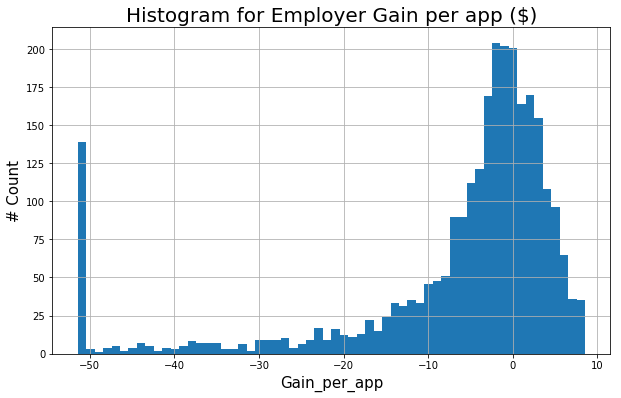

In [68]:
hist_plot("Gain_per_app",1,"Employer Gain per app ($)",0.05, 0.99)

count    2748.000000
mean       -9.431235
std        83.674318
min     -2962.127800
1%       -136.833494
2%       -105.443511
5%        -62.525552
10%       -40.579817
25%       -21.046219
50%        -7.392959
75%         7.587920
90%        26.080911
95%        41.798550
98%        77.372196
99%       114.887091
max      1938.874065
Name: Gain_per_day, dtype: float64


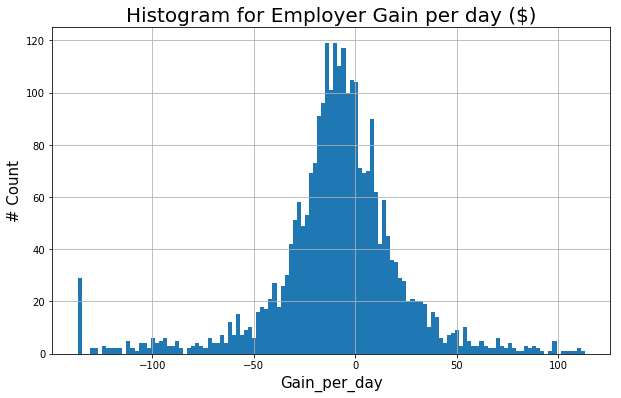

In [69]:
hist_plot("Gain_per_day",2,"Employer Gain per day ($)",0.01, 0.99)

count    2748.000000
mean       -0.108844
std         0.476172
min        -0.999945
1%         -0.952281
2%         -0.922184
5%         -0.805464
10%        -0.668987
25%        -0.398335
50%        -0.146619
75%         0.148635
90%         0.455324
95%         0.671733
98%         0.960468
99%         1.164322
max         8.618265
Name: ROI, dtype: float64


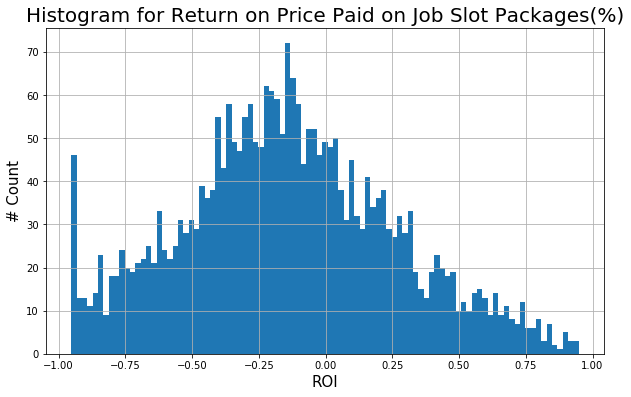

In [71]:
hist_plot("ROI",0.02,"Return on Price Paid on Job Slot Packages(%)",0.01, 0.98)

## PART 2:  RETENTION ANALYSIS

### What factor or combination of factors best predict likelihood to retain (i.e., Renewed = 1)?  

In [72]:
# target variable: Last_renewed
# Correlated attributes
# Overall delivery value, Job location, last-time package performance, completition, previous renew history (renew rate)
# Choose top 4 locations
job["CA"] = job["Employer State"].apply(lambda x: 1 if x == "California" else 0)
job["NY"] = job["Employer State"].apply(lambda x: 1 if x == "New York State" else 0)
job["FL"] = job["Employer State"].apply(lambda x: 1 if x == "Florida" else 0)
job["TX"] = job["Employer State"].apply(lambda x: 1 if x == "Texas" else 0)
employer_top4loc = job.groupby("Employer ID")["CA","NY","FL","TX"].sum().reset_index()
print(employer_top4loc.shape)
employer_model = employer_all.merge(employer_top4loc, left_on = "Employer ID", right_on = "Employer ID", how = "left")
print(employer_model.shape)

(2748, 5)
(2748, 41)


In [73]:
employer_model.head(1)

,Employer ID,Number of Slots,Price Paid,Marketplace Value Delivered,Applications,# Renewed,term,NA_num,Last Date,Last #Slots,...,MV_pkg,Employer_Gain,Gain_per_app,Gain_per_day,Gain_per_pkg,ROI,CA,NY,FL,TX
0,40,125,67125.0,147711.043445,9647.7,0,394,0,2016-02-29,125,...,147711.043445,80586.043445,8.352876,204.533105,80586.043445,1.200537,1,0,0,0


In [74]:
# Calculated attributes for the latest contract
employer_model["last_total_Gain"] = employer_model["Last MKT Value"] - employer_model["Last Price Paid"]
employer_model["last_ROI"] = employer_model["last_total_Gain"]/employer_model["Last Price Paid"]
employer_model["last_gain_day"] = employer_model["last_total_Gain"]/employer_model["last term"]
employer_model["last_gain_app"] = employer_model["last_total_Gain"]/employer_model["Last Apps"]
employer_model["last_cost_app"] = employer_model["Last Price Paid"]/employer_model["Last Apps"]
employer_model["last_cost_day"] = employer_model["Last Price Paid"]/employer_model["last term"]
employer_model["last_MKT_app"] = employer_model["Last MKT Value"]/ employer_model["Last Apps"]
employer_model["last_MKT_day"] = employer_model["Last MKT Value"]/ employer_model["last term"]
employer_model["last_app_day"] = employer_model["Last Apps"]/employer_model["last term"]
# Calculated attributes for overall performance
employer_model["total_hist"] = employer_model.apply(lambda row: day_between(row["Earliest Date"], row["Last Date"]), axis = 1)
employer_model["# prev renew"] = employer_model["# Renewed"] - employer_model["End Renewed"]
employer_model["term per package"] = employer_model["term"]/employer_model["# Packages"]

In [77]:
employer_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 2747
Data columns (total 69 columns):
Employer ID                    2748 non-null int64
Number of Slots                2748 non-null int64
Price Paid                     2748 non-null float64
Marketplace Value Delivered    2748 non-null float64
Applications                   2748 non-null float64
# Renewed                      2748 non-null int64
term                           2748 non-null int64
NA_num                         2748 non-null int64
Last Date                      2748 non-null datetime64[ns]
Last #Slots                    2748 non-null int64
Last Price Paid                2748 non-null float64
Last MKT Value                 2748 non-null float64
Last Apps                      2748 non-null float64
End Renewed                    2748 non-null int64
last term                      2748 non-null int64
Earliest Date                  2748 non-null datetime64[ns]
Loc count                      2748 non-null in

In [78]:
# last time value only applies for populaton with renews
employer_model["last_renew"] = employer_model["# prev renew"].apply(lambda x: 1 if x > 0 else 0)
employer_model["last_total_gain_renew"] = employer_model["last_total_Gain"] * employer_model["last_renew"]
employer_model["last_ROI_renew"] = employer_model["last_ROI"] * employer_model["last_renew"]
employer_model["last_gain_day_renew"] = employer_model["last_gain_day"] * employer_model["last_renew"]
employer_model["last_gain_app_renew"] = employer_model["last_gain_app"] * employer_model["last_renew"]
employer_model["last_cost_app_renew"] = employer_model["last_cost_app"] * employer_model["last_renew"]
employer_model["last_cost_day_renew"] = employer_model["last_cost_day"] * employer_model["last_renew"]
employer_model["last_MKT_app_renew"] = employer_model["last_MKT_app"] * employer_model["last_renew"]
employer_model["last_MKT_day_renew"] = employer_model["last_MKT_day"] * employer_model["last_renew"]
employer_model["last_app_day_renew"] = employer_model["last_app_day"] * employer_model["last_renew"]
employer_model["Last #Slots_renew"] = employer_model["Last #Slots"] * employer_model["last_renew"]
employer_model["Last Price Paid_renew"] = employer_model["Last Price Paid"] * employer_model["last_renew"]
employer_model["Last MKT value_renew"] = employer_model["Last MKT Value"] * employer_model["last_renew"]
employer_model["Last Apps_renew"] = employer_model["Last Apps"] * employer_model["last_renew"]
employer_model["Last term_renew"] = employer_model["last term"] * employer_model["last_renew"]
employer_model["total_hist_renew"] = employer_model["total_hist"] * employer_model["last_renew"]

In [79]:
def renew_rate(row):
    if row["# Packages"] == 1:
        return -1
    else:
        return row["# prev renew"]/(row["# Packages"] - 1)
employer_model["prev renew rate"] = employer_model.apply(lambda row: renew_rate(row), axis = 1)
# multiple package
employer_model["multi_pack"] = employer_model["# Packages"].apply(lambda x: 1 if x > 1 else 0)
employer_model["multi_pack_prev_renew_rate"] = employer_model["multi_pack"] * employer_model["prev renew rate"]

In [80]:
# get dummy variables for job market
employer_model = pd.concat([employer_model,pd.get_dummies(employer_model["job_mkt"])],axis = 1)

In [81]:
# Check target attributes
employer_model["End Renewed"].value_counts()

1    1780
0     959
2       8
3       1
Name: End Renewed, dtype: int64

In [82]:
# Define target variable: End Renewed > 1 (in the last contract, whether Employer renewed the contract in the end
employer_model["retained"] = employer_model["End Renewed"].apply(lambda x: 1 if x >= 1 else 0)
employer_model["retained"].mean()

0.651018922852984

In [83]:
# Check null value for attributes
employer_model.isnull().sum().sum()

0

In [84]:
# Independent variables
dropcol = ["last_renew","last_total_Gain","last_ROI","last_gain_day","last_gain_app","last_cost_app","last_cost_day",
           "last_MKT_app","last_MKT_day","last_app_day",
           "Last #Slots", "Last Price Paid","Last MKT Value", "Last Apps", "last term", "total_hist",
           "Employer ID", "Employer ID","Last Date","Earliest Date","# Renewed","int_mkt","us_mkt",
           "job_mkt","retained", "End Renewed", "app_per_slot"]
X,y = employer_model.drop(dropcol,axis = 1), employer_model["retained"]==1

In [115]:
# Cap/floor extreme value ;
def extre_value(row):
    if row[col] < X[col].quantile(0.01):
        row[col] = X[col].quantile(0.01)
    elif row[col] > X[col].quantile(0.99):
        row[col] = X[col].quantile(0.99)
    return row[col]

for col in X.columns:
    X[col] = X.apply(lambda x: extre_value(x), axis = 1)

In [116]:
# Generate train/validation samples
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0, test_size= 0.3)
print(X_train.shape[0], X_test.shape[0])

(1923, 825)


In [117]:
y_train.mean(), y_test.mean()

(0.65106604264170564, 0.65090909090909088)

In [118]:
from sklearn import cross_validation
from sklearn import metrics

In [119]:
def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
#Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    train_predictions = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:,1]
    test_predictions = alg.predict(X_test)
    test_predprob = alg.predict_proba(X_test)[:,1]
    
#     #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy(Train): %.4g" % metrics.accuracy_score(y_train.values, train_predictions)
    print "Accuracy(Test) : %.4g" % metrics.accuracy_score(y_test.values, test_predictions)
    print "Precision(Train): %.4g" % metrics.precision_score(y_train.values, train_predictions)
    print "Precision(Test): %.4g" % metrics.precision_score(y_test.values, test_predictions)
    print "Recall(Train): %.4g" % metrics.recall_score(y_train.values, train_predictions)
    print "Recall(Test): %.4g" % metrics.recall_score(y_test.values, test_predictions)        
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, train_predprob)
    print "AUC Score (Test): %f" % metrics.roc_auc_score(y_test, test_predprob)
    
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy(Train): 0.7223
Accuracy(Test) : 0.7127
Precision(Train): 0.7189
Precision(Test): 0.7155
Recall(Train): 0.9417
Recall(Test): 0.9274
AUC Score (Train): 0.738107
AUC Score (Test): 0.670608
CV Score : Mean - 0.6238522 | Std - 0.01606514 | Min - 0.5968865 | Max - 0.646597


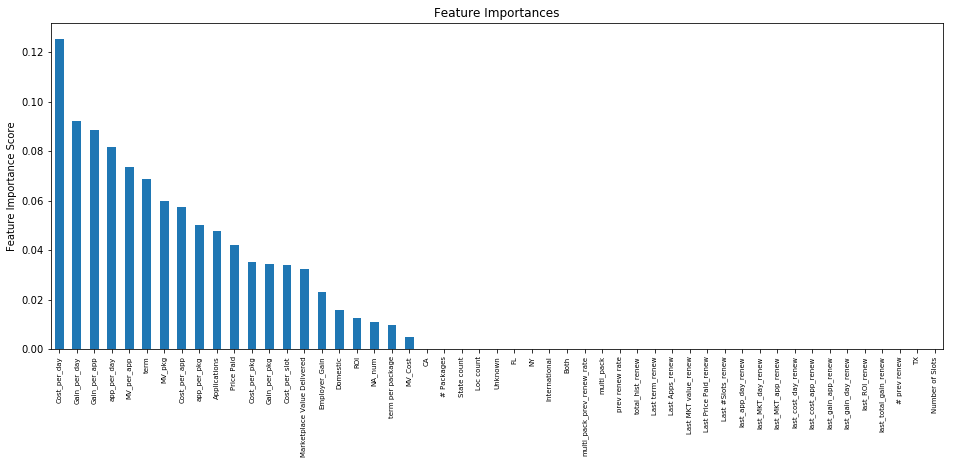

In [120]:
#Choose all predictors except target & IDcols
rcParams['figure.figsize'] = 16, 6
gbm0 = GradientBoostingClassifier(max_depth = 4,  min_samples_split = 500, min_samples_leaf = 300)
modelfit(gbm0, X_train, y_train, X_test, y_test)


Model Report
Accuracy(Train): 0.7192
Accuracy(Test) : 0.7115
Precision(Train): 0.7158
Precision(Test): 0.7133
Recall(Train): 0.9433
Recall(Test): 0.9311
AUC Score (Train): 0.723855
AUC Score (Test): 0.673168
CV Score : Mean - 0.6149054 | Std - 0.01595129 | Min - 0.5982441 | Max - 0.6371642


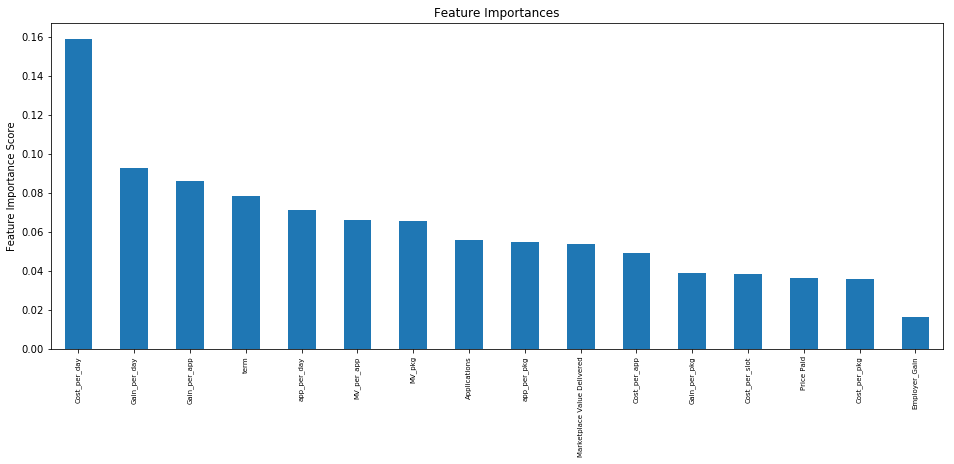

In [121]:
#Tune Model to feature w. importance > 0.02
feature_df = pd.DataFrame({'Features': X_train.columns, "Feature Importance": gbm0.feature_importances_}).sort_values("Feature Importance", ascending = False)
columns = feature_df[feature_df["Feature Importance"] >= 0.02]["Features"]
X_train_refine = X_train[columns]
#X_train_refine.shape
X_test_refine = X_test[columns]
gbm1 = GradientBoostingClassifier(max_depth = 3,  min_samples_split = 500, min_samples_leaf = 300)
modelfit(gbm1, X_train_refine, y_train, X_test_refine, y_test)

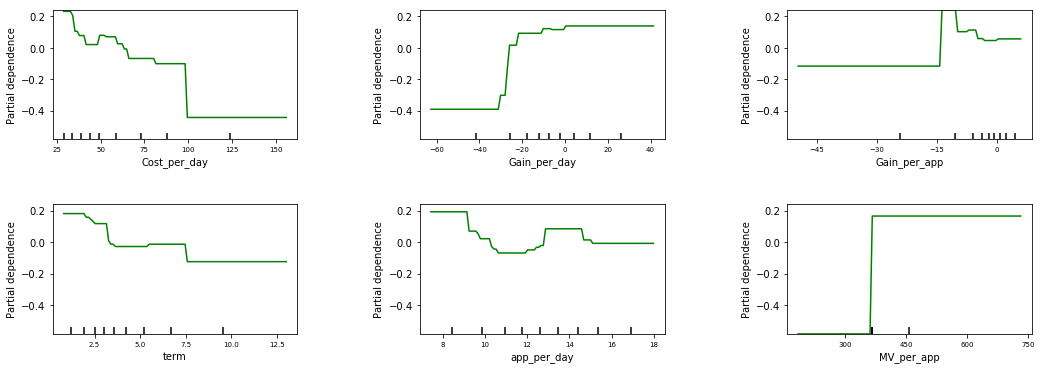

In [122]:
# Plot Partial Dependence
ftimp_gbm1 = gbm1.feature_importances_
ft_gbm1 = X_train_refine.columns
matplotlib.rc('xtick', labelsize = 7)
feature_gbm1 = pd.DataFrame({"Features": ft_gbm1, "Feature Importance": ftimp_gbm1}).sort_values(by = "Feature Importance", ascending = False).reset_index().drop("index", axis = 1)
feature_matrx = np.arange(6)
fig, axs = plot_partial_dependence(gbm1, X_train_refine, feature_matrx, feature_names = feature_gbm1.Features, 
                                   n_jobs = 3, grid_resolution = 100)
plt.subplots_adjust(top = 0.9, wspace = 0.5, hspace = 0.5)

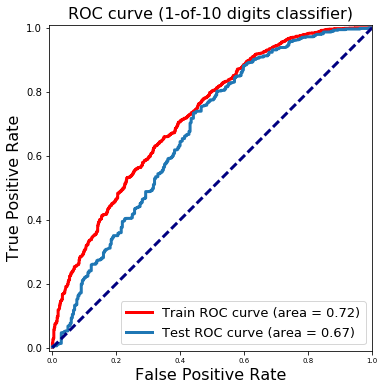

In [123]:
# PLOT ROC
from sklearn.metrics import roc_curve, auc

y_score_train = gbm1.fit(X_train_refine, y_train).decision_function(X_train_refine)
y_score_lr = gbm1.fit(X_train_refine, y_train).decision_function(X_test_refine)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, y_score_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_train = auc(fpr_lr_train, tpr_lr_train)


plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_train, tpr_lr_train, lw=3, c = "red", label='Train ROC curve (area = {:0.2f})'.format(roc_auc_train))
plt.plot(fpr_lr, tpr_lr, lw=3, label='Test ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [96]:
# build a logistic regression based on it

In [ ]:
# get rid of columsn highly correlated
col = ["Cost_per_day", "Gain_per_day","MV_per_app","Gain_per_app","term","MV_pkg","Cost_per_app","Price Paid","Cost_per_slot",
        "Domestic","NA_num", "MV_Cost","term per package"]

In [ ]:
from sklearn import preprocessing
X_train_sc = pd.DataFrame(preprocessing.scale(X_train_refine))
X_test_sc = pd.DataFrame(preprocessing.scale(X_test_refine))

In [1250]:
logreg = LogisticRegression()

param_range = np.linspace(0.01,1.01,20)
train_recall, test_recall = validation_curve(logreg, X = X_train_sc, y = y_train.astype(int), param_name = "C",
                                            param_range = param_range, cv = 5, scoring = "recall", n_jobs = 1)
CV_recall_mean = np.mean(test_recall, axis = 1)
CV_recall_std = np.std(test_recall, axis = 1)
best = param_range[np.where(CV_recall_mean == CV_recall_mean.max())][0]

In [1251]:
best

0.01

In [1252]:
# fit the regression
logreg = LogisticRegression(C = best)
logreg = logreg.fit(X_train_sc, y_train.astype(int))
pred_y_test = logreg.predict(X_test_sc)
preba_y_test = logreg.predict_proba(X_test_sc)

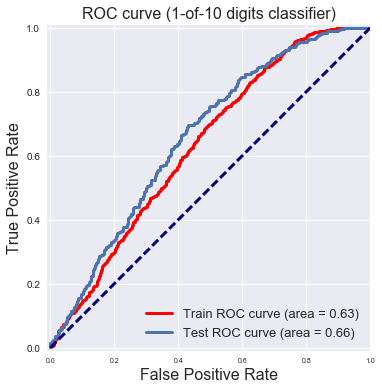

In [1253]:
# PLOT ROC
y_score_train = logreg.fit(X_train_sc, y_train).decision_function(X_train_sc)
y_score_lr = logreg.fit(X_train_sc, y_train).decision_function(X_test_sc)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, y_score_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_train = auc(fpr_lr_train, tpr_lr_train)


plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_train, tpr_lr_train, lw=3, c = "red", label='Train ROC curve (area = {:0.2f})'.format(roc_auc_train))
plt.plot(fpr_lr, tpr_lr, lw=3, label='Test ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [1254]:
coef = pd.DataFrame(list(zip(X_train_refine.columns,logreg.coef_.tolist()[0])),columns = ["variable name","estimates"]).sort_values(by = "estimates", ascending = False)
coef

,variable name,estimates
4,term,0.244162
1,Gain_per_day,0.178141
9,app_per_pkg,0.124152
14,Employer_Gain,0.079773
11,Applications,0.071851
5,MV_pkg,0.054457
10,Cost_per_pkg,0.052202
3,Gain_per_app,0.049872
6,app_per_day,0.043924
7,Gain_per_pkg,0.028910


In [ ]:
# Insights based on the findings (Top 6 features in GBM)
# Segment with one-pkg user and multi-pkg user, and/or international/ domestic empployer

In [98]:
employer_model["multi_pkg_user"] = employer_model["# Packages"].apply(lambda x: 1 if x > 1 else 0)
employer_model.multi_pkg_user.value_counts()

0    2449
1     299
Name: multi_pkg_user, dtype: int64

In [99]:
employer_model.job_mkt.value_counts()

Domestic         1691
Unknown           676
International     336
Both               45
Name: job_mkt, dtype: int64

In [101]:
# Category job market
def pop_jobloc(row):
    if row["CA"]==1 or row["FL"] == 1 or row["TX"] == 1 or row["NY"] == 1:
        return 1
    else:
        return 0
employer_model["pop_jobloc"] = employer_model.apply(lambda row: pop_jobloc(row), axis = 1)

In [105]:
# Cost per day by one-purchase/ multi-purchase
# define cost by quantile;
def group_hist(colname):
    ax = employer_model.groupby(colname)["retained"].mean().reset_index().set_index(col_name).rename()


In [142]:
def groups(row, colname):
    if row[colname] < employer_model[colname].quantile(0.1):
        return "LOW"
    elif row[colname] < employer_model[colname].quantile(0.5):
        return "LOW - MED"
    elif row[colname] > employer_model[colname].quantile(0.9):
        return 'HIGH'
    else:
        return 'MED - HIGH'

employer_model["Cost_per_day_grp"] = employer_model.apply(lambda row: groups(row, "Cost_per_day"), axis = 1)

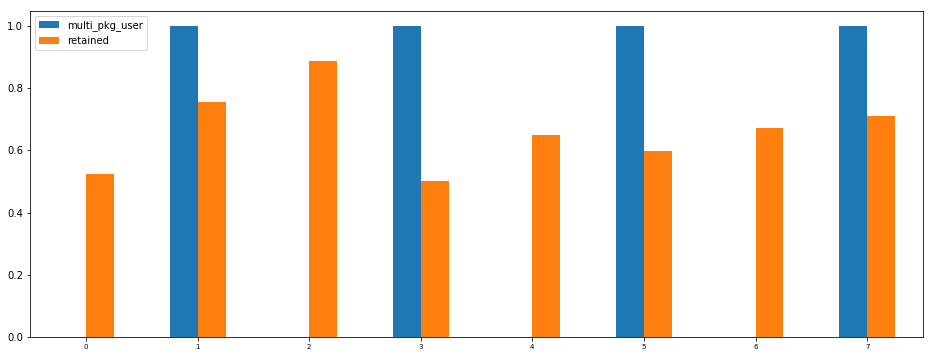

In [157]:
#temp1 = employer_model[employer_model["multi_pkg_user"]==1]


In [151]:
employer_model["Cost_per_day_grp"].value_counts().to_frame().reset_index().rename(columns = {"index": "Cost per day group",
                                                                                             "Cost_per_day_grp": "count"})

,Cost per day group,Cost_per_day_grp
0,LOW - MED,1282
1,MED - HIGH,1184
2,HIGH,271
3,LOW,11
